[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Asterios7/torch_image_classifier/blob/main/notebooks/OxfordIIITPet_classification.ipynb)

##  Image Classification for OxfordIIITPet

In [ ]:
# Install dependencies
!pip install torchmetrics torchinfo

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import  summary
from torchmetrics import Accuracy
from tqdm.auto import tqdm
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from datetime import date

# Get utility modules from github in they don't exist
try:
    from utilities.torchTrain import torchTrain
    from utilities.util_functions import plot_loss_curves, save_model, load_model
except:
    print("Getting utility modules from https://github.com/Asterios7/torch_image_classifier ")
    !git clone https://github.com/Asterios7/torch_image_classifier
    !mv torch_image_classifier/utilities .
    !rm -rf torch_image_classifier
    from utilities.torchTrain import torchTrain
    from utilities.util_functions import plot_loss_curves, save_model, load_model

torch.__version__, torchvision.__version__

Getting utility modules from https://github.com/Asterios7/torch_image_classifier 
Cloning into 'torch_image_classifier'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 13), reused 31 (delta 8), pack-reused 0
Receiving objects: 100% (40/40), 17.78 KiB | 4.44 MiB/s, done.
Resolving deltas: 100% (13/13), done.


('2.0.1+cu118', '0.15.2+cu118')

In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Create data transforms
Create transform with normalization to match the data distribution of the EfficientNetB0

Alternative approach:
```
# 1. Setup pretrained EffNetB0 weights
effnetb0_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB0 transforms
effnetb0_transforms = effnetb2_weights.transforms()
```

In [4]:
# Create EffnetB0 model data transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense the transformation
    transforms.ToTensor()
    # normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

### Get the OxfordIIITPet dataset

In [5]:
# Load train and test datasets
train_dataset = datasets.OxfordIIITPet(root="data",
                                       split="trainval",
                                       transform=train_transforms,
                                       download=True);

test_dataset = datasets.OxfordIIITPet(root="data",
                                     split="test",
                                     transform=test_transforms,
                                     download=True);

class_names = train_dataset.classes
class_names_idx = train_dataset.class_to_idx

100%|██████████| 791918971/791918971 [00:21<00:00, 36763693.58it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 17308739.19it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


### Select a subset for experimentation

In [6]:
# Define a list of class indices you want to keep (0-based)
selected_classes = [0, 1, 2]  # Select the first three classes

# Filter the dataset to keep only the specified classes
train_dataset = [item for item in train_dataset if item[1] in selected_classes]
test_dataset = [item for item in train_dataset if item[1] in selected_classes]


In [7]:
print(f"Train dataset number of samples: {len(train_dataset)}")
print(f"Test dataset number of samples: {len(test_dataset)}")


Train dataset number of samples: 300
Test dataset number of samples: 300


In [8]:
# # Check for imbalance
# from collections import Counter

# targets = [train_dataset[i][1] for i in np.arange(0, len(train_dataset))]
# class_counts = Counter(targets)
# print(f"Class counts: {class_counts}")

### Visualize images

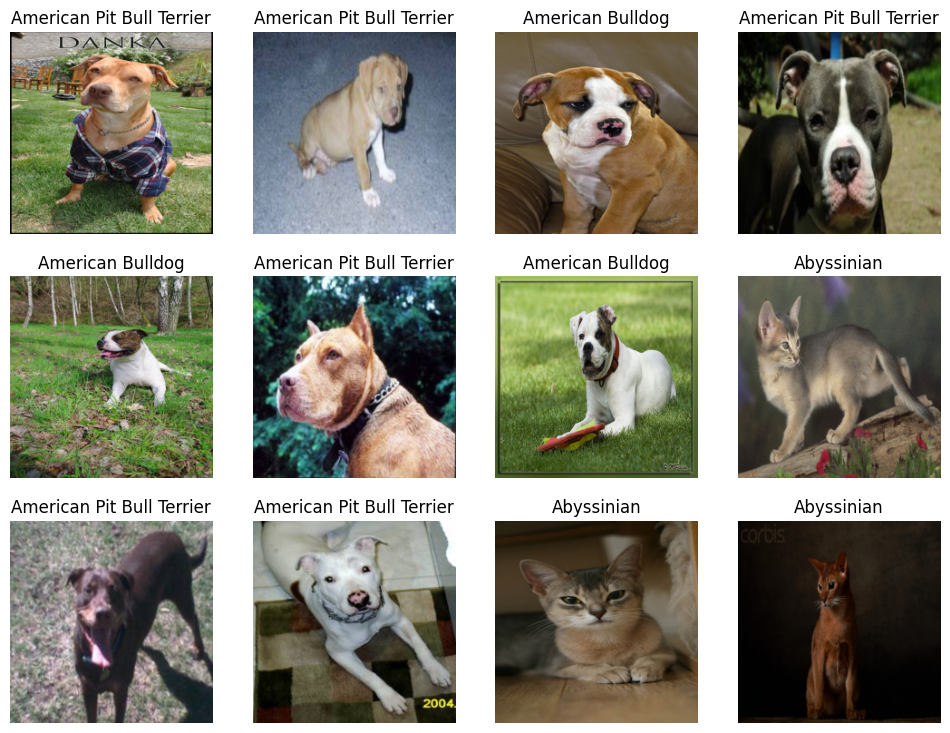

In [9]:
nrows = 3
ncols = 4

random.seed(13)
# Select random images from train dataset
random_images = []
random_labels = []
for idx in random.sample(list(np.arange(0, len(train_dataset))), k=nrows*ncols):
    random_images.append(train_dataset[idx][0])
    random_labels.append(train_dataset[idx][1])

# Plot random images with labels
plt.figure(figsize=(12, 9))

for i, sample_image in enumerate(random_images):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample_image.permute(1, 2, 0))
    plt.title(class_names[random_labels[i]])
    plt.axis(False)

### Create Dataloaders

In [10]:
# Set batch_size and num_workers
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print number of batches
print(f"Train DataLoader number of batches: {len(train_dataloader)}")
print(f"Test DataLoader number of batches: {len(test_dataloader)}")
print(f"Batch shape: {next(iter(train_dataloader))[0].shape}") # (batch_size, color_channels, height, width)

Train DataLoader number of batches: 10
Test DataLoader number of batches: 10
Batch shape: torch.Size([32, 3, 224, 224])


### Create EfficientNet_B0

In [11]:
# Get model weights
effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# Create a model instance
effnetb0 = torchvision.models.efficientnet_b0(weights=effnetb0_weights)
# Freeze the base layers in the mode0
for param in effnetb0.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 76.6MB/s]


In [12]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

# Change the classifier layer (trainable)
effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

In [13]:
from torchinfo import summary

summary(effnetb0,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 37]              --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Train Model

In [14]:
# Select optimizer
optimizer = torch.optim.Adam(params=effnetb0.parameters(),
                             lr=1e-3)

# Set loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set accuracy function
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names))

# Instantiate torchTrain class
trainer = torchTrain()

In [15]:
torch.manual_seed(13)
results = trainer.train(model=effnetb0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        epochs=5,
                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.4190 | Train acc: 0.4417 | Test loss: 1.7419 | Test acc: 0.6635
Epoch: 1 | Train loss: 1.1325 | Train acc: 0.8062 | Test loss: 1.0694 | Test acc: 0.8865
Epoch: 2 | Train loss: 0.7173 | Train acc: 0.9083 | Test loss: 0.6772 | Test acc: 0.9396
Epoch: 3 | Train loss: 0.5331 | Train acc: 0.9292 | Test loss: 0.4657 | Test acc: 0.9844
Epoch: 4 | Train loss: 0.4020 | Train acc: 0.9719 | Test loss: 0.3653 | Test acc: 0.9844


### Plot Loss & Accuracy Curves

In [16]:
plot_loss_curves(results)

### Save model in `models` folder


In [26]:
today = date.today()
save_model(model=effnetb0,
           target_dir='models',
           model_name=f"effnetb0_{today}_test-acc-{int(results['test_acc'][-1]*1e+4)}.pt")

[INFO] Saving model to: models/effnetb0_2023-09-22_test-acc-9843.pt
